In [1]:
#Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import requests
from bs4 import BeautifulSoup
%matplotlib inline

#Turn off chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Get the list of available movies and metadata from FML
r = requests.get("https://fantasymovieleague.com/researchvault?section=box-office")
soup = BeautifulSoup(r.content, 'lxml')

#Find the relevant table, clean it up
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]
df.drop(df.columns[0], axis=1, inplace=True) #The HTML table has an extra column of 1-indexed ranks
df.columns = df.columns.droplevel() #The HTML table has an erroneous multi-index

#Split name column to get FML price and name stored separately
df["price"] = df.iloc[:,0].str.split("$", n=0, expand=True)[1]
df["name"] = df.iloc[:,0].str.split("FB", n=0, expand=True)[0]
firststep = df.drop(df.columns[0], axis = 1) #Drop the old name column
firststep

,Earnings,%Change,Earnings,%Change,Earnings,%Change,Earnings,%Change,price,name
0,$30.0M,-36.9%,$47.6M,-27.9%,$66.0M,-,-,-,351,SAT - Black Panther - SAT ONLY
1,$19.4M,-45.1%,$35.3M,-41.2%,$60.1M,-,-,-,263,SUN - Black Panther - SUN ONLY
2,$17.0M,-,-,-,-,-,-,-,176,Red Sparrow
3,$16.3M,-43.4%,$28.8M,-62.1%,$75.9M,-,-,-,205,FRI - Black Panther - FRI ONLY
4,$13.0M,-,-,-,-,-,-,-,167,Death Wish
5,$10.7M,-37.0%,$17.0M,-,-,-,-,-,97,Game Night
6,$10.0M,-21.6%,$12.8M,-45.4%,$23.4M,-6.5%,$25.0M,-,94,Peter Rabbit
7,$5.7M,-49.0%,$11.1M,-,-,-,-,-,53,Annihilation
8,$4.5M,-20.4%,$5.7M,-43.6%,$10.0M,-0.1%,$10.0M,-8.3%,42,Jumanji: Welcome to the Jungle
9,$3.3M,-53.7%,$7.1M,-63.2%,$19.4M,-49.6%,$38.6M,-,30,Fifty Shades Freed


In [3]:
#Deal with the special case of Blockbuster movies being split by day
firststep["day"] = 'ALL'
cleaned = firststep
days = ['FRI','SAT','SUN']

#If movie is split by day, store that row's day in "day" column
cleaned.loc[cleaned.name.str.contains('|'.join(days)),"day"] = cleaned[
    cleaned.name.str.contains('|'.join(days))].name.str.split(" - ", n=0, expand=True)[0]

#If movie is split by day, store that row's cleaned name in "name" column
cleaned.loc[cleaned.name.str.contains('|'.join(days)),"name"] = cleaned[
    cleaned.name.str.contains('|'.join(days))].name.str.split(" - ", n=0, expand=True)[1]

#Rename columns, drop irrelevant columns
cleaned.columns.values[[0,2,4,6]] = ["lastweek","2weeksago","3weeksago","4weeksago"]
final = cleaned.drop(cleaned.columns[[1,3,5,7]], axis = 1)
final

,lastweek,2weeksago,3weeksago,4weeksago,price,name,day
0,$30.0M,$47.6M,$66.0M,-,351,Black Panther,SAT
1,$19.4M,$35.3M,$60.1M,-,263,Black Panther,SUN
2,$17.0M,-,-,-,176,Red Sparrow,ALL
3,$16.3M,$28.8M,$75.9M,-,205,Black Panther,FRI
4,$13.0M,-,-,-,167,Death Wish,ALL
5,$10.7M,$17.0M,-,-,97,Game Night,ALL
6,$10.0M,$12.8M,$23.4M,$25.0M,94,Peter Rabbit,ALL
7,$5.7M,$11.1M,-,-,53,Annihilation,ALL
8,$4.5M,$5.7M,$10.0M,$10.0M,42,Jumanji: Welcome to the Jungle,ALL
9,$3.3M,$7.1M,$19.4M,$38.6M,30,Fifty Shades Freed,ALL


In [22]:
#Before getting daily numbers from the-numbers.com, we need movie names in the format the-numbers uses for URLs.
#Luckily, the-numbers.com has consistent URL conventions!

final["url_part"] = final["name"]

the_mask = final["url_part"].str.startswith("The ")
final.loc[the_mask, "url_part"] = final.loc[the_mask, "url_part"].str.replace("The ","") + " The" #Move "The" to end
final["url_part"] = final["url_part"].str.replace(' ', '-')

#colons with a space after are removed (as in "Jumani: "), and other string cleaning
final["url_part"] = final["url_part"].str.replace(': ',' ')
final["url_part"] = final["url_part"].str.replace(',','')
final["url_part"] = final["url_part"].str.replace('!','')
final["url_part"] = final["url_part"].str.replace('.','')
final["url_part"] = final["url_part"].str.replace('\'','')
#colons within words or numbers (as in "15:17") are replaced with dashes
final["url_part"] = final["url_part"].str.replace(':', '-')
final

,lastweek,2weeksago,3weeksago,4weeksago,price,name,day,url_part
0,$30.0M,$47.6M,$66.0M,-,351,Black Panther,SAT,Black-Panther
1,$19.4M,$35.3M,$60.1M,-,263,Black Panther,SUN,Black-Panther
2,$17.0M,-,-,-,176,Red Sparrow,ALL,Red-Sparrow
3,$16.3M,$28.8M,$75.9M,-,205,Black Panther,FRI,Black-Panther
4,$13.0M,-,-,-,167,Death Wish,ALL,Death-Wish
5,$10.7M,$17.0M,-,-,97,Game Night,ALL,Game-Night
6,$10.0M,$12.8M,$23.4M,$25.0M,94,Peter Rabbit,ALL,Peter-Rabbit
7,$5.7M,$11.1M,-,-,53,Annihilation,ALL,Annihilation
8,$4.5M,$5.7M,$10.0M,$10.0M,42,Jumanji: Welcome to the Jungle,ALL,Jumanji--Welcome-to-the-Jungle
9,$3.3M,$7.1M,$19.4M,$38.6M,30,Fifty Shades Freed,ALL,Fifty-Shades-Freed


In [5]:
#This function takes in one of the cleaned URL_parts we made above and grabs the associated data from the-numbers.com

def get_table(row):
    try:
        r = requests.get("https://www.the-numbers.com/movie/{}-(2018)".format(row))
        soup = BeautifulSoup(r.content, 'lxml')
        table = soup.find_all(id = 'box_office_chart')[1]   
        movie = pd.read_html(str(table))[0]
        movie.columns = movie.iloc[0]
        movie = movie[1:]
        movie["Gross"] = movie["Gross"].str.replace('\$|,','')
        print("Found and stored data for {}-(2018)!".format(row))
        return movie
    except IndexError: #the-numbers.com sometimes includes movie year, sometimes does not
        print("No luck finding {}-(2018), will try adding -(2017)".format(row))
        try:
            r = requests.get("https://www.the-numbers.com/movie/{}-(2017)".format(row))
            soup = BeautifulSoup(r.content, 'lxml')
            table = soup.find_all(id = 'box_office_chart')[1]   
            movie = pd.read_html(str(table))[0]
            movie.columns = movie.iloc[0]
            movie = movie[1:]
            movie["Gross"] = movie["Gross"].str.replace('\$|,','')
            print("Found and stored data for {}-2017!".format(row))
            return movie
        except IndexError: #the-numbers.com mislabeled "Death With" as from 2017...
            print("No luck finding {}-(2017) either. Will try removing year specification.".format(row))
            try:
                r = requests.get("https://www.the-numbers.com/movie/{}".format(row))
                soup = BeautifulSoup(r.content, 'lxml')
                table = soup.find_all(id = 'box_office_chart')[1]   
                movie = pd.read_html(str(table))[0]
                movie.columns = movie.iloc[0]
                movie = movie[1:]
                movie["Gross"] = movie["Gross"].str.replace('\$|,','')
                print("Found and stored data for {}!".format(row))
                return movie
            except IndexError:
                print("Looks like {} doesn't exist on the-numbers.com. Try a google search?".format(row))

In [6]:
#Incredibly, the forecast part is one of the easiest.

def forecast(df):
    #fbprophet requires one "y" column for values and one "ds" column for dates
    df["y"] = pd.to_numeric(df["Gross"])
    df["ds"] = pd.to_datetime(df["Date"], format = '%Y/%m/%d')
    m = Prophet(changepoint_prior_scale=.5) #default 0.05, higher values make the trend fit more flexible
    m.fit(df)
    future_data = m.make_future_dataframe(periods=7) #forecast a week to make sure we capture next week's numbers
    fcast_data = m.predict(future_data)
    m.plot(fcast_data)
    plt.ylabel("Forecast of Daily Gross")
    plt.title(row)
    plt.show()
    return fcast_data

No luck finding Black-Panther-(2018), will try adding -(2017)
No luck finding Black-Panther-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.


Found and stored data for Black-Panther!


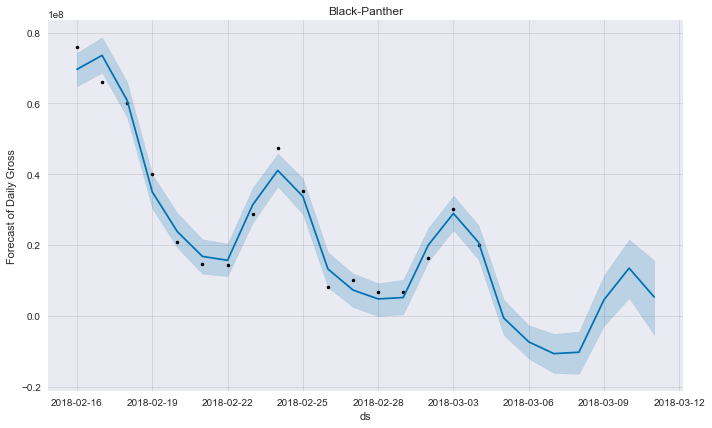

No luck finding Black-Panther-(2018), will try adding -(2017)
No luck finding Black-Panther-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.


Found and stored data for Black-Panther!


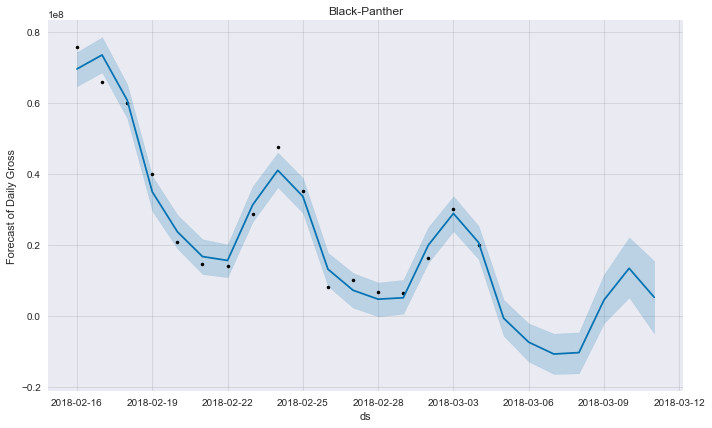

No luck finding Red-Sparrow-(2018), will try adding -(2017)
No luck finding Red-Sparrow-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 1.0.


Found and stored data for Red-Sparrow!


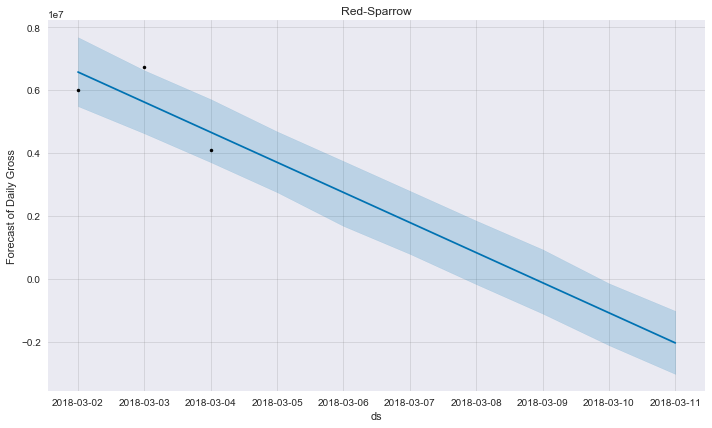

No luck finding Black-Panther-(2018), will try adding -(2017)
No luck finding Black-Panther-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.


Found and stored data for Black-Panther!


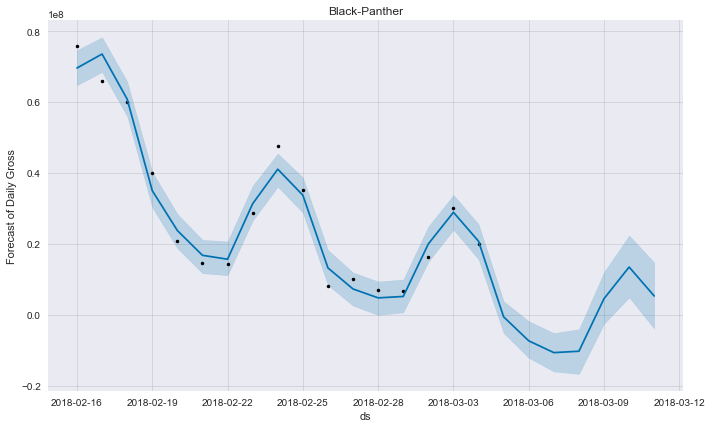

No luck finding Death-Wish-(2018), will try adding -(2017)


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 1.0.


Found and stored data for Death-Wish-2017!


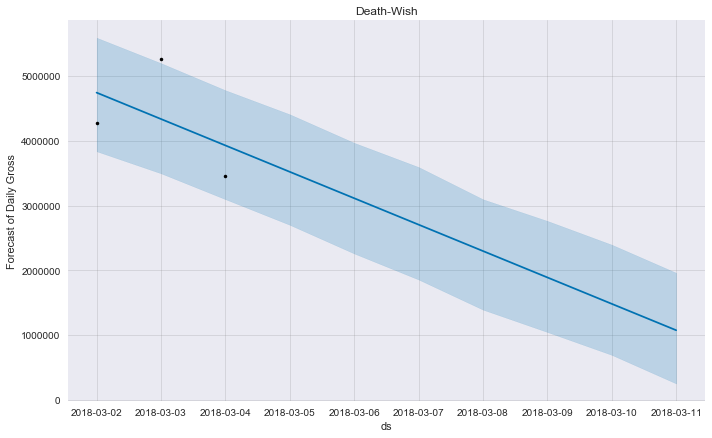

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 7.0.


Found and stored data for Game-Night-(2018)!


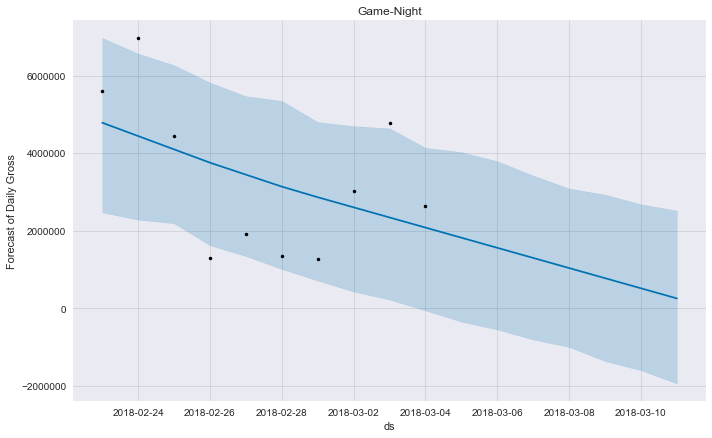

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 18.0.


Found and stored data for Peter-Rabbit-(2018)!


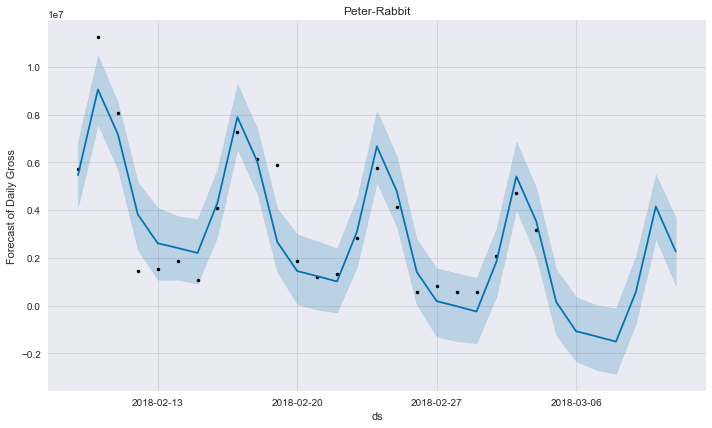

No luck finding Annihilation-(2018), will try adding -(2017)
No luck finding Annihilation-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 7.0.


Found and stored data for Annihilation!


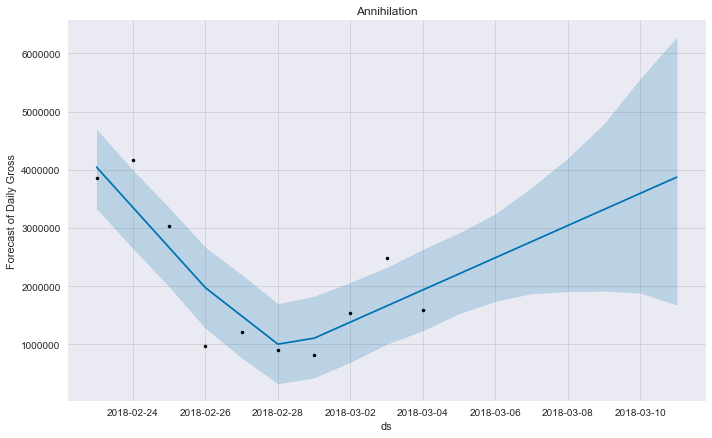

No luck finding Jumanji--Welcome-to-the-Jungle-(2018), will try adding -(2017)
No luck finding Jumanji--Welcome-to-the-Jungle-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Jumanji--Welcome-to-the-Jungle!


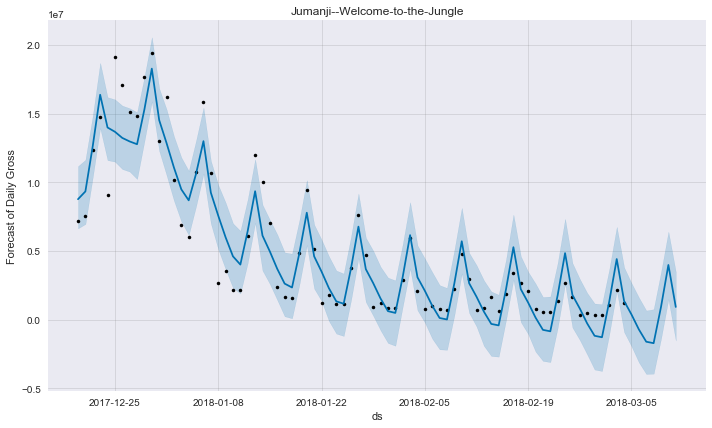

No luck finding Fifty-Shades-Freed-(2018), will try adding -(2017)
No luck finding Fifty-Shades-Freed-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 18.0.


Found and stored data for Fifty-Shades-Freed!


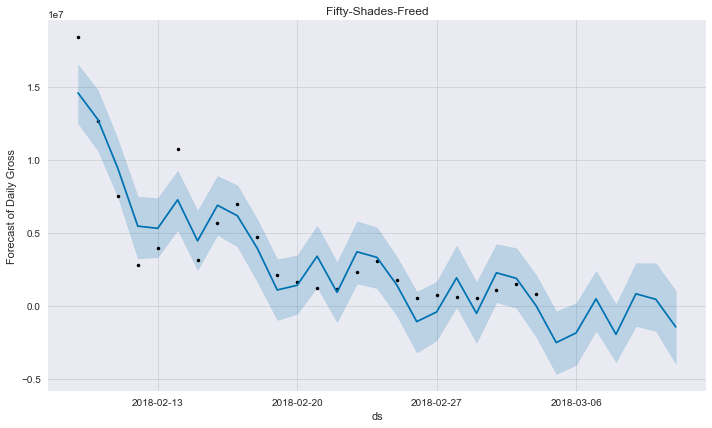

No luck finding Greatest-Showman-The-(2018), will try adding -(2017)
No luck finding Greatest-Showman-The-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Greatest-Showman-The!


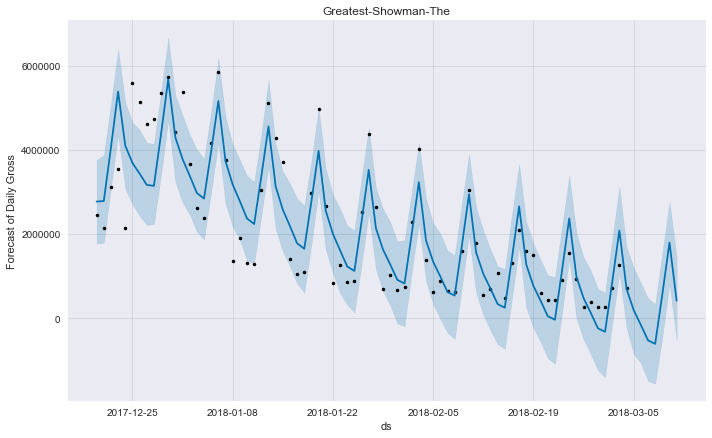

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


Found and stored data for Every-Day-(2018)!


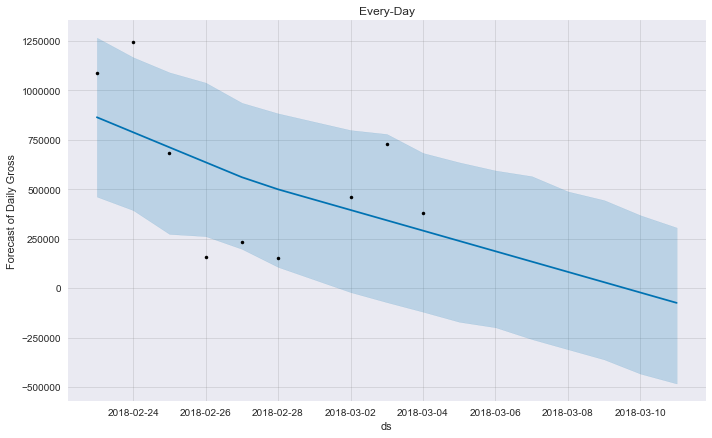

No luck finding 15-17-to-Paris-The-(2018), will try adding -(2017)
No luck finding 15-17-to-Paris-The-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 18.0.


Found and stored data for 15-17-to-Paris-The!


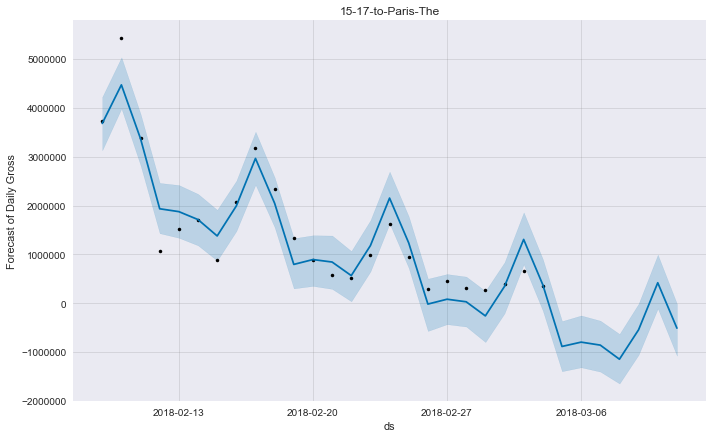

No luck finding Shape-of-Water-The-(2018), will try adding -(2017)
No luck finding Shape-of-Water-The-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Shape-of-Water-The!


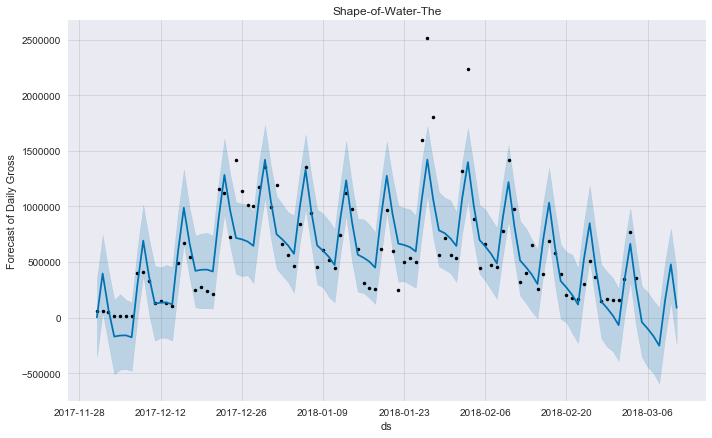

No luck finding Three-Billboards-Outside-Ebbing-Missouri-(2018), will try adding -(2017)
No luck finding Three-Billboards-Outside-Ebbing-Missouri-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Three-Billboards-Outside-Ebbing-Missouri!


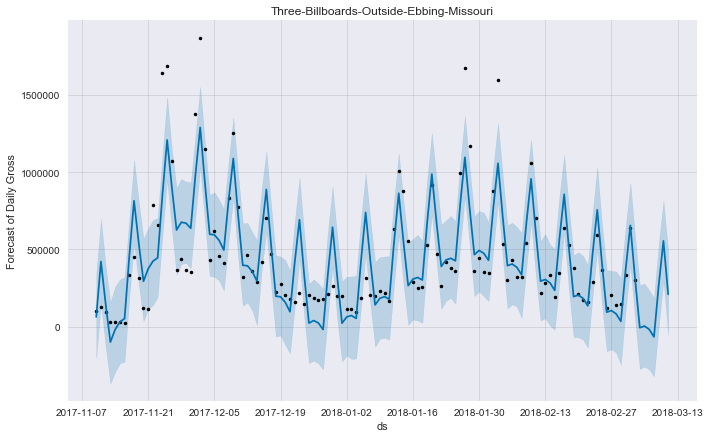

In [21]:
for row in final["url_part"]:
    movie = get_table(row)
    fcast_data = forecast(movie)

Everything below this point is in progress
===

No luck finding Black-Panther-(2018), will try adding -(2017)
No luck finding Black-Panther-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.


Found and stored data for Black-Panther!


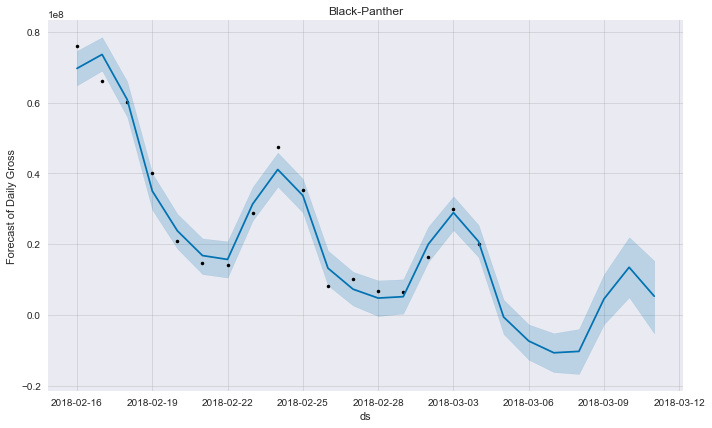

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat,day
0,2018-02-16,6.208731e+07,6.208731e+07,6.208731e+07,6.486234e+07,7.461426e+07,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,6.964389e+07,FRI
1,2018-02-17,5.490231e+07,5.490231e+07,5.490231e+07,6.900600e+07,7.844941e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,7.358321e+07,SAT
2,2018-02-18,4.813008e+07,4.813008e+07,4.813008e+07,5.595927e+07,6.593018e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,6.085215e+07,SUN
3,2018-02-19,4.143881e+07,4.143881e+07,4.143881e+07,2.972260e+07,3.999315e+07,-6.411999e+06,-6.411999e+06,-6.411999e+06,-6.411999e+06,-6.411999e+06,-6.411999e+06,-6.411999e+06,-6.411999e+06,-6.411999e+06,3.502681e+07,MON
4,2018-02-20,3.474753e+07,3.474753e+07,3.474753e+07,1.872498e+07,2.852161e+07,-1.096949e+07,-1.096949e+07,-1.096949e+07,-1.096949e+07,-1.096949e+07,-1.096949e+07,-1.096949e+07,-1.096949e+07,-1.096949e+07,2.377804e+07,TUE
5,2018-02-21,2.887410e+07,2.887410e+07,2.887410e+07,1.155447e+07,2.160758e+07,-1.208928e+07,-1.208928e+07,-1.208928e+07,-1.208928e+07,-1.208928e+07,-1.208928e+07,-1.208928e+07,-1.208928e+07,-1.208928e+07,1.678482e+07,WED
6,2018-02-22,2.517582e+07,2.517582e+07,2.517582e+07,1.058237e+07,2.079992e+07,-9.488778e+06,-9.488778e+06,-9.488778e+06,-9.488778e+06,-9.488778e+06,-9.488778e+06,-9.488778e+06,-9.488778e+06,-9.488778e+06,1.568704e+07,THU
7,2018-02-23,2.379132e+07,2.379132e+07,2.379132e+07,2.667131e+07,3.613876e+07,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,7.556581e+06,3.134790e+07,FRI
8,2018-02-24,2.240683e+07,2.240683e+07,2.240683e+07,3.624489e+07,4.585109e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,1.868089e+07,4.108772e+07,SAT
9,2018-02-25,2.102218e+07,2.102218e+07,2.102218e+07,2.896444e+07,3.844898e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,1.272207e+07,3.374425e+07,SUN


In [20]:
df = get_table("Black-Panther")
df["y"] = pd.to_numeric(df["Gross"])
df["ds"] = pd.to_datetime(df["Date"], format = '%Y/%m/%d')
m = Prophet(changepoint_prior_scale=.5) #default 0.05, higher values make the trend fit more flexible
m.fit(df)
future_data = m.make_future_dataframe(periods=7) #forecast a week to make sure we capture next week's numbers
fcast_data = m.predict(future_data)
m.plot(fcast_data)
plt.ylabel("Forecast of Daily Gross")
plt.title(row)
plt.show()
fcast_data["day"] = fcast_data["ds"].dt.weekday_name
day_abb = {"Monday" : "MON"
           , "Tuesday" : "TUE"
           , "Wednesday" : "WED"
           , "Thursday" : "THU"
           , "Friday" : "FRI"
           , "Saturday" : "SAT"
           , "Sunday" : "SUN"}
fcast_data["day"] = fcast_data["day"].map(day_abb)
fcast_data